In [1]:
import os
import sys
sys.path.append('/home/kevinteng/Desktop/DE_Project')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from coord_conv import CoordConv
import cv2
import utils
import utils_vis
import utils_model
from sklearn.model_selection import train_test_split

---------------------

# Retrieving and Preprocess Data

Image size:  100


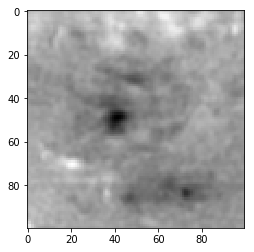

In [2]:
dataset = np.load('/home/kevinteng/Desktop/DeepLearning/Tensorflow2_0/test_npy/7-12-17-processed_dF.npy')
NEW_SIZE = 100
#re_list = dataset
re_list = utils.resize(dataset, NEW_SIZE)
IMG_SIZE = re_list.shape[1]

print('Image size: ', IMG_SIZE)
#Dimension for network should include the color channel 
re_list = np.expand_dims(re_list, axis = -1)
#Cast data type to float32 for TensorFlow
re_list = re_list.astype('float32')

for img in re_list:
    plt.imshow(np.reshape(img, (IMG_SIZE, IMG_SIZE)), cmap = 'gray')
    plt.show()
    
    break
    
#     if input()=='exit':
#         break

(100, 100, 1) float32


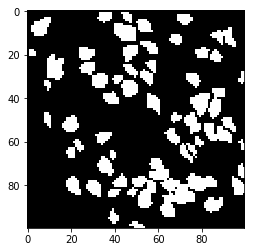

In [3]:
#retrieve and plot mean_ROI
mean_roi = np.load("/home/kevinteng/Desktop/Manual_Annotation/7-12-17_ROImask.npy")
mean_roi = cv2.resize(mean_roi, (NEW_SIZE, NEW_SIZE))
#Dimension for network should include the color channel 
mean_roi = np.expand_dims(mean_roi, axis = -1)
#Cast data type to float32 for TensorFlow
mean_roi = mean_roi.astype('float32')

print(mean_roi.shape, mean_roi.dtype)
plt.imshow(np.squeeze(mean_roi), cmap = 'gray')

In [4]:
# centres, img_with_centroids = utils.retrieve_centroid(mean_roi, centroid_rad = 2)

# plt.imshow(np.squeeze(img_with_centroids), cmap = 'gray')
# plt.show()
# print('With centroids:')
# print(centres)

In [5]:
#calculate max image

max_img_ori = utils.max_in_pro(re_list,len(re_list), IMG_SIZE, IMG_SIZE)
#apply min max norm for mean image
max_img_ori = utils.min_max_norm(max_img_ori)
#max_img_ori = np.expand_dims(max_img_ori, -1)
print('Max value:', np.max(max_img_ori))
print('Min value:', np.min(max_img_ori))


Max value: 1.0
Min value: 0.0


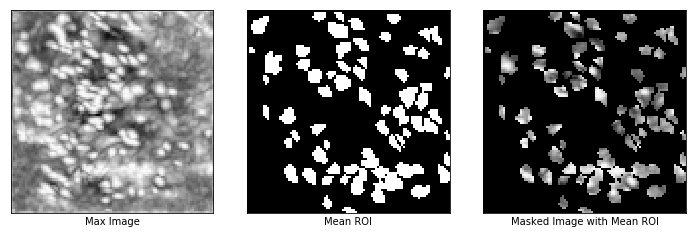

MSE:  0.3339316650390625
Dice coefficient:  0.3229142634187343


In [6]:
from utils import masked_img, dice_coef_py, MSE_image
from utils_vis import plot_comparison

captions = ['Max Image', 'Mean ROI', 'Masked Image with Mean ROI']
plot_comparison([max_img_ori, mean_roi,masked_img(max_img_ori, mean_roi)], 
                captions, n_col =3, figsize = (10, 10))
print('MSE: ', MSE_image(np.squeeze(max_img_ori), mean_roi, IMG_SIZE))
#measure IOU with dice coeff
print('Dice coefficient: ',dice_coef_py(mean_roi, max_img_ori))

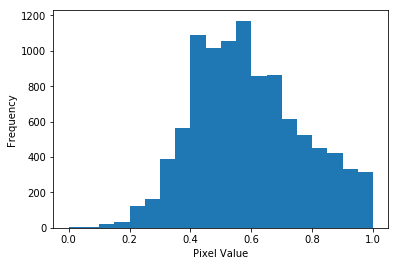

In [7]:
#plot historgram for mean image
plt.hist(max_img_ori.ravel(),20,[0,1])
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

----------------------------------------------------------


# Model

In [8]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.regularizers import l1
from utils_model import conv_block, coordconv_block


l1_coeff = 0.99
filters_layer = [32, 64]

#build network
def Coord_conv(input_layer):
    coordconv_01 = coordconv_block(input_layer, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                      filters = filters_layer[0], kernel_size = 3, strides = 1, padding='same', 
                                       activation='relu', batch_norm = False)
    coordconv_02 = coordconv_block(coordconv_01, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                      filters = filters_layer[1], kernel_size = 3, strides = 1, padding='same', 
                                       activation='relu', batch_norm = False)
    coordconv_03 = coordconv_block(coordconv_02, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                      filters = 1, kernel_size = 3, strides = 1, padding='same',
                                      activation = 'sigmoid')
    return coordconv_03

def Convnet(input_layer):
    conv_01 = conv_block(input_layer, filters = filters_layer[0], kernel_size = 3, strides = 1, 
                             padding = 'same',  activation = 'relu',batch_norm = True) 
    conv_02 = conv_block(conv_01, filters = filters_layer[1], kernel_size = 3, strides = 1, 
                             padding = 'same',  activation = 'relu',
                         batch_norm = True)
    conv_03 = conv_block(conv_02, filters = 1, kernel_size = 3, strides = 1, 
                             padding = 'same',  activation = 'sigmoid') 
    return conv_03
        
        

## Build Model

In [9]:
coordconv = True #toggle for coordconv and regular convnet
input_layer = Input(shape = (IMG_SIZE, IMG_SIZE, 1))

if coordconv:
    print('The model is in Coordconv')
    model = Model(input_layer, Coord_conv(input_layer))
else:
    print('The model is in regular Conv-net')
    model = Model(input_layer, Convnet(input_layer))

The model is in Coordconv


-----------------------------------------------------------------

In [10]:
batch_imgs = utils.batch_dataset(re_list, 16, IMG_SIZE)

print(batch_imgs.shape[0])

38


## Train Model

In [11]:
from utils_model import img_mean, min_max_norm, dice_coef_loss

#hyperparameter
BATCH_SIZE = 16
lr = 0.0005
#loss function
#loss_fn = tf.losses.MeanSquaredError()
loss_fn = tf.losses.BinaryCrossentropy()

#optimizer 
opt = tf.optimizers.Adam(lr)

@tf.function
def train(batched_imgs, mean_roi, img_size):
    with tf.GradientTape() as tape:
        #number of batches for indexing
        n_batch = batch_imgs.shape[0]
        stack_batch = tf.TensorArray(tf.float32, size = n_batch)
        
        #loop for batches 
        for i in tf.range(n_batch):
            #feed the network with batches 
            conv_img = model(batched_imgs[i])
            #take the max of the batch with batch size
            batch_max = tf.reduce_max(conv_img, 0)
            #stack the number of batch for each loop in number of batches
            stack_batch = stack_batch.write(i, batch_max)
        
        #return stack_batch after .write() with index
        stack_batch = stack_batch.stack()
        #total max of sequence 
        max_img = tf.reduce_max(stack_batch, 0)
        #max_img = min_max_norm(max_img)
        xent = loss_fn(mean_roi, max_img)
        #xent = dice_coef_loss(mean_roi, max_img)
        
    grads = tape.gradient(xent, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    
    return xent, max_img, grads

ori_list = [] #original image list
de_list = [] #max image fromt the network list
loss_list = [] #loss list

img_batch = re_list
epochs = 0

batch_imgs = utils.batch_dataset(re_list, BATCH_SIZE, IMG_SIZE)

while epochs < 30:
    xent, max_img, grads =train(batch_imgs, mean_roi, IMG_SIZE)
    de_list.append(max_img)
    loss_list.append(xent)

    print("Epochs {:2d}, Loss: {}".format(epochs, xent.numpy()))
    print("Gradient min:{}, max:{}".format(np.min(grads[0]), np.max(grads[0])))
    print()
    epochs+=1

W1014 10:28:32.750026 140537543288576 deprecation.py:323] From /home/kevinteng/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1220: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epochs  0, Loss: 5.1472883224487305
Gradient min:-20.12346839904785, max:28.94734764099121

Epochs  1, Loss: 0.9120614528656006
Gradient min:-1.5979365110397339, max:1.4157747030258179

Epochs  2, Loss: 0.7611702680587769
Gradient min:-0.34072345495224, max:0.335633784532547

Epochs  3, Loss: 0.7060150504112244
Gradient min:-0.28698480129241943, max:0.3104102909564972

Epochs  4, Loss: 0.6595672369003296
Gradient min:-0.25289320945739746, max:0.2632927894592285

Epochs  5, Loss: 0.6280611157417297
Gradient min:-0.07504158467054367, max:0.06832163035869598

Epochs  6, Loss: 0.6139705777168274
Gradient min:-0.014487036503851414, max:0.01310604065656662

Epochs  7, Loss: 0.6025102138519287
Gradient min:-0.01477165799587965, max:0.013520431704819202

Epochs  8, Loss: 0.5918419361114502
Gradient min:-0.014738612808287144, max:0.013649052008986473

Epochs  9, Loss: 0.5818052887916565
Gradient min:-0.014529953710734844, max:0.013739999383687973

Epochs 10, Loss: 0.572376549243927
Gradient min

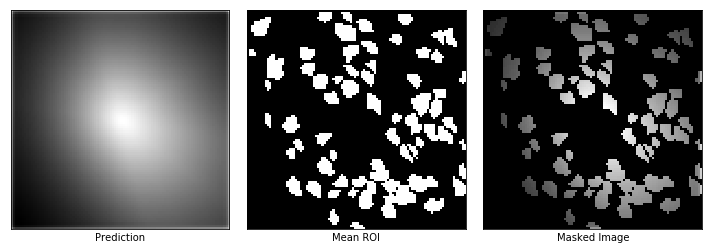

Loss: 0.5126662
Dice coefficient:  0.2289441167787962



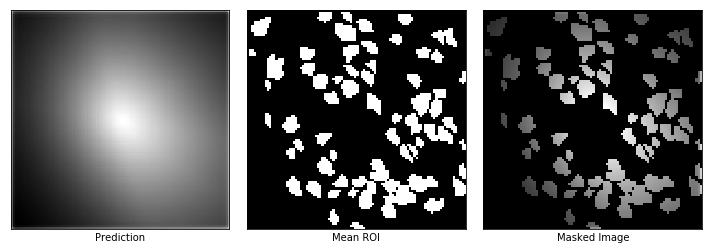

Loss: 0.51276135
Dice coefficient:  0.2269213290701081



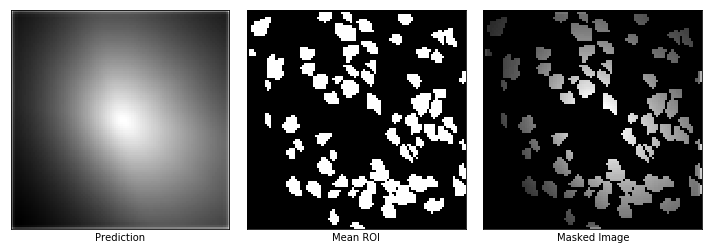

Loss: 0.5128831
Dice coefficient:  0.2254353409020551



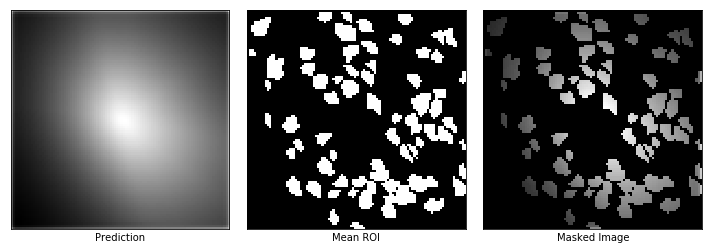

Loss: 0.512969
Dice coefficient:  0.224483296550457



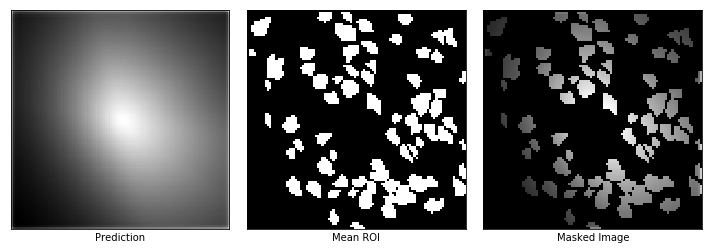

Loss: 0.5129755
Dice coefficient:  0.22404432434637742


In [12]:
#plot for mean image of last 10 steps w.r.t mean roi 
last_n_steps = 5
for i in range(last_n_steps):
    max_image = de_list[len(de_list) - last_n_steps + i]
    max_image = np.asarray(max_image) #cast tf object into np array
    masked_image = masked_img(max_image, mean_roi)
    
    #plot
    inp_imgs = [max_image , mean_roi, masked_image]
    captions = ['Prediction',
               'Mean ROI', 
               'Masked Image']
    plot_comparison(inp_imgs, captions,n_col = 3, figsize = (10,10))
    
    print('Loss:', loss_list[len(de_list) - last_n_steps + i].numpy())
    print('Dice coefficient: ', dice_coef_py(mean_roi, max_image))

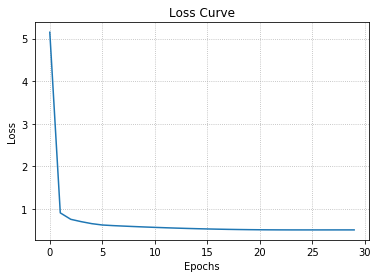

In [13]:
xlabel = 'Epochs'
ylabel = 'Loss'
title = 'Loss Curve'
utils_vis.plot_loss(loss_list, xlabel, ylabel, title)

-------------------------------------------------

# Predict

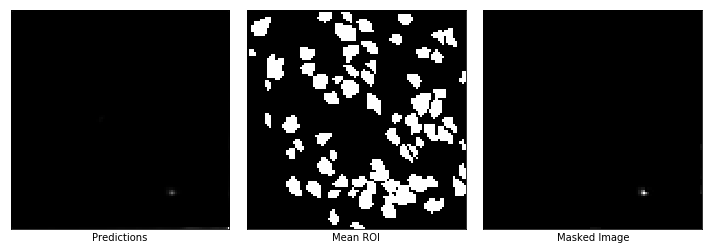

MSE for predicted image:  0.211369482421875
Dice coefficient:  0.00238234480365671



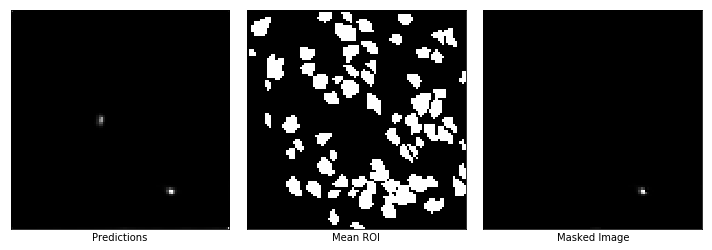

MSE for predicted image:  0.2111264892578125
Dice coefficient:  0.005661773357264027



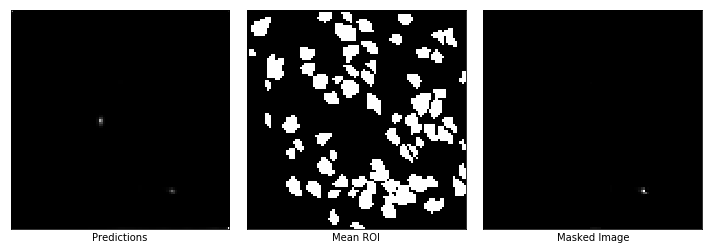

MSE for predicted image:  0.211658984375
Dice coefficient:  0.0014060385622159115



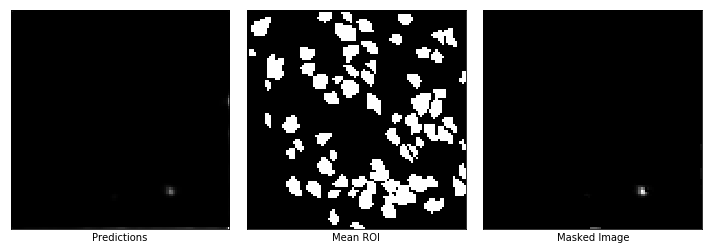

MSE for predicted image:  0.2110466064453125
Dice coefficient:  0.004989093837032119



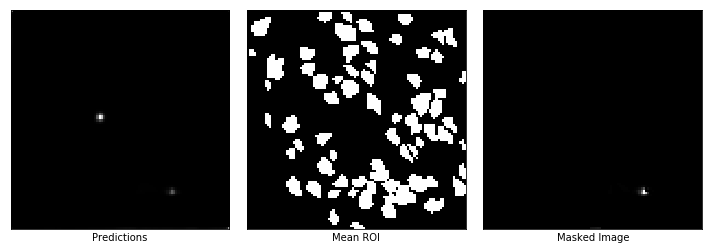

MSE for predicted image:  0.21168330078125
Dice coefficient:  0.0024303000029261726


In [14]:
sums = 0
slices = 20 #slices of image from image stack 
n = 5

#create data generator for test set
ds_test = tf.data.Dataset.from_tensor_slices(re_list).batch(slices)

for i, (test_batch) in enumerate(ds_test):
    assert test_batch.shape[0] == slices

    conv_img = model(test_batch)
    max_img = tf.reduce_max(conv_img,0)
    max_img = min_max_norm(max_img)

    max_image = np.asarray(max_img) #cast tf object into np array
    masked_image = masked_img(max_image, mean_roi)
    inp_imgs = [np.squeeze(max_image), mean_roi, masked_image]

    captions = ['Predictions',
               'Mean ROI', 
               'Masked Image']
    plot_comparison(inp_imgs, captions, n_col = 3,figsize = (10,10))

    print('MSE for predicted image: ', MSE_image(max_img, mean_roi, IMG_SIZE))
    print('Dice coefficient: ', dice_coef_py(mean_roi, max_image))
    
    sums+=1

    #plot only n images for prediction
    if sums == n:
        break

-----------------------------------------------

# Visualizing Feature Maps

In [15]:
from utils_vis import layers_dict, feature_maps, plot_feature_maps, layers_name

layer_dict = layers_dict(model)
layer_name = layers_name(model)

input_1
coord_conv_1
activation
coord_conv_3
activation_1
coord_conv_5
activation_2


In [16]:
if coordconv:
    layer_name = 'coord_conv'
else:
    layer_name = 'conv2d'
    
# layer_output = layer_dict[layer_name].output

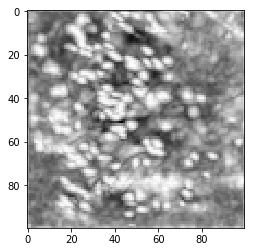

In [17]:
# taking the mean over all stacks as input
test_img = np.asarray(tf.expand_dims(max_img_ori, 0)) #(1, img size, img size, 1)
#test_img = tf.expand_dims(test_img, -1) #(1, img size, img size, 1)
plt.imshow(np.squeeze(test_img), cmap = 'gray')
plt.show()

## Visualizing Last Layer of Feature Maps

In [18]:
# test_map = feature_maps(model, '{}_3'.format(layer_name), test_img)
# plot_feature_maps(test_map, 8, 8, figsize = (20,20))

## Visualizing First Layer of Feature Maps

In [19]:
# test_map02 = feature_maps(model, '{}_1'.format(layer_name), test_img)
# plot_feature_maps(test_map02, 4, 8, figsize = (20,20))

--------------------------------

# Appendix

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
coord_conv_1 (CoordConv)     (None, 100, 100, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 100, 100, 32)      0         
_________________________________________________________________
coord_conv_3 (CoordConv)     (None, 100, 100, 64)      19648     
_________________________________________________________________
activation_1 (Activation)    (None, 100, 100, 64)      0         
_________________________________________________________________
coord_conv_5 (CoordConv)     (None, 100, 100, 1)       595       
_________________________________________________________________
activation_2 (Activation)    (None, 100, 100, 1)       0     